In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32

In [ ]:
data_set=tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/ColabNotebooks/Plant_data',shuffle=True,seed=32)

Found 2152 files belonging to 3 classes.


In [ ]:
names=data_set.class_names
print(names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


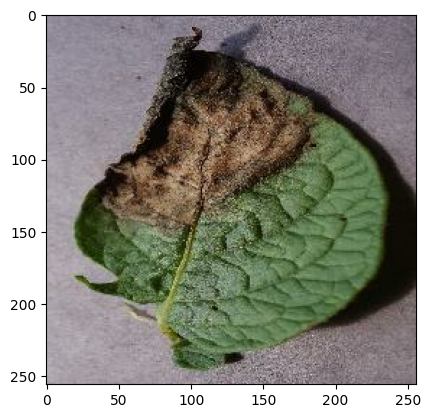

In [ ]:
for image_batch, label_batch in data_set.take(1):
    #print(image_batch[0])
    plt.imshow(image_batch[0].numpy().astype('uint8'))

In [ ]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in data_set.take(1):
    #print(image_batch[0])
    for k in range(10):
        plt.subplot(2,5,k+1)
        plt.title(names[label_batch[k]])
        plt.imshow(image_batch[k].numpy().astype('uint8'))

Output hidden; open in https://colab.research.google.com to view.

# Train_Test split

In [ ]:
# train_size = int(len(data_set)*0.8)
# train_set = data_set.take(train_size)
# remaining_data = data_set.skip(train_size)
# val_size=int(len(data_set)*0.1)
# val_set = remaining_data.take(val_size)
# test_set = remaining_data.skip(val_size)

In [ ]:
#Based on the logic above
def dataset_partition(data, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=1000):
    if shuffle:
        data = data.shuffle(shuffle,shuffle_size)
    data_size = len(data)
    train_size = int(data_size*train_split)
    train_set = data.take(train_size)
    val_size = int(data_size*val_split)
    remaining_data = data.skip(train_size)
    val_set = remaining_data.take(val_size)
    test_set = remaining_data.skip(val_size)

    return train_set,val_set,test_set

In [ ]:
train_data,val_data,test_data = dataset_partition(data_set)

In [ ]:
# Memory optimization
train_data=train_data.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Data preparation
# resize_rescale_layer = tf.keras.Sequential([
#     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE), # to make sure that even for different sizes this model will work in future
#     layers.experimental.preprocessing.Rescaling(1.0/255)

# ])

augmentation_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
base_model= tf.keras.applications.ResNet50V2(include_top=False)
input_= tf.keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
preprocess_2=augmentation_layer(input_)
x_layer= tf.keras.applications.resnet_v2.preprocess_input(preprocess_2)
base_layer=base_model(x_layer, training=False)
pool_layer = tf.keras.layers.GlobalAvgPool2D()(base_layer)
tune_layer = tf.keras.layers.Dropout(0.2)(pool_layer)
output_ = tf.keras.layers.Dense(3,activation='softmax')(tune_layer)
my_model = tf.keras.Model(inputs=input_,outputs=output_)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048   23564800  
                             )                                   
                                                             

In [ ]:
len(base_model.layers)

190

In [ ]:
for layer in base_model.layers[:187]:
    layer.trainable=False

In [ ]:
my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048   23564800  
                             )                                   
                                                             

In [ ]:
my_model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics='accuracy')

In [ ]:
model_history = my_model.fit(train_data, batch_size=BATCH_SIZE, epochs=100, verbose=1,
                          validation_data=val_data,
                      callbacks=tf.keras.callbacks.EarlyStopping(patience=3))

Epoch 1/100
54/54 [==============================] - 222s 545ms/step - loss: 0.5346 - accuracy: 0.7598 - val_loss: 0.2601 - val_accuracy: 0.8958
Epoch 2/100
54/54 [==============================] - 7s 133ms/step - loss: 0.2318 - accuracy: 0.9265 - val_loss: 0.2015 - val_accuracy: 0.9271
Epoch 3/100
54/54 [==============================] - 7s 132ms/step - loss: 0.1820 - accuracy: 0.9352 - val_loss: 0.1548 - val_accuracy: 0.9531
Epoch 4/100
54/54 [==============================] - 7s 135ms/step - loss: 0.1530 - accuracy: 0.9537 - val_loss: 0.1492 - val_accuracy: 0.9375
Epoch 5/100
54/54 [==============================] - 7s 133ms/step - loss: 0.1356 - accuracy: 0.9606 - val_loss: 0.1407 - val_accuracy: 0.9635
Epoch 6/100
54/54 [==============================] - 7s 135ms/step - loss: 0.1173 - accuracy: 0.9630 - val_loss: 0.1415 - val_accuracy: 0.9479
Epoch 7/100
54/54 [==============================] - 8s 143ms/step - loss: 0.1162 - accuracy: 0.9612 - val_loss: 0.1171 - val_accuracy: 0.96

In [ ]:
score = my_model.evaluate(test_data)

8/8 [==============================] - 5s 229ms/step - loss: 0.0475 - accuracy: 0.9828


In [ ]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']

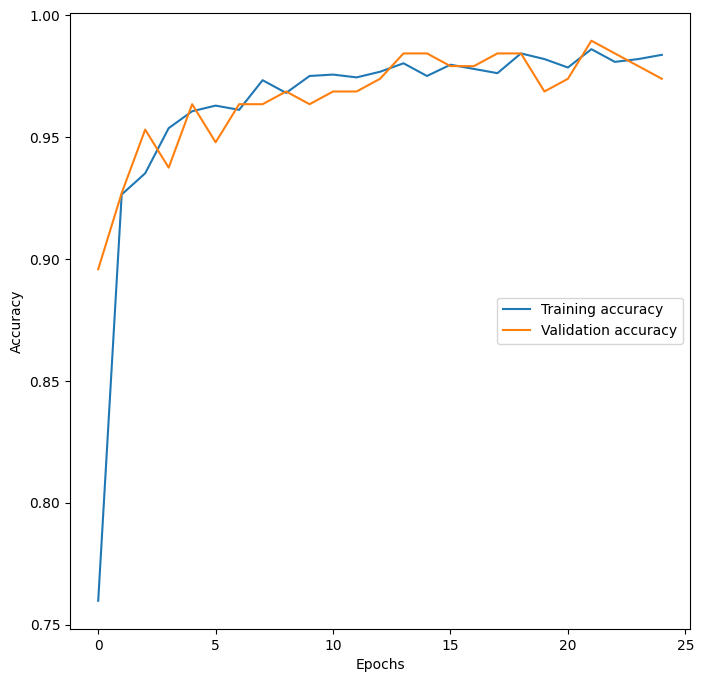

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(range(25),acc,label='Training accuracy')
plt.plot(range(25),val_acc,label='Validation accuracy')
plt.legend(loc='center right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Evaluation of predictions

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 987ms/step
predicted label: Potato___Early_blight


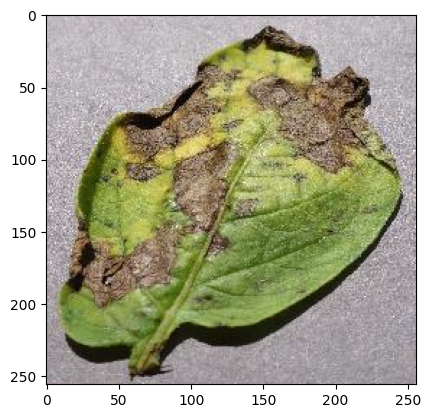

In [ ]:
for im_batch, lable_batch in test_data.take(1):
  first_im = im_batch[0].numpy().astype('uint8')
  first_label=label_batch[0].numpy()
  print('first image to predict')
  plt.imshow(first_im)
  print('actual label:',names[first_label])
  pred=my_model.predict(im_batch)
  print('predicted label:',names[np.argmax(pred[0])])

In [ ]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
  img_array= tf.expand_dims(img_array,axis=0) # to convert image to a (1,len,width,channel) batch
  pred = model.predict(img_array)
  pred_class = names[np.argmax(pred)]
  confidence = round(100*np.max(pred),2)
  return pred_class, confidence

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_data.take(1):
  for i in range(9):
    # plt.figure(figsize=(15,15))
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    pred_class, confidence=predict(my_model,images[i])
    actual_class = names[labels[i]]
    plt.title(f"Actual label: {actual_class}, \n predicted label:{pred_class}, \n Confidence: {confidence}")
    plt.axis('off')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
my_model.save(f"/content/drive/My Drive/ColabNotebooks/my_model.keras")